En esta actividad veremos un caso práctico sobre cómo se guardan y controlan las distintas versiones de los modelos empleando MLfow y GitHub. <br>

Primero, vamos a necesitar cargar una serie de librerías que serán de utilidad para la carga de los modelos, reentrenamiento en el caso de ser necesario y actualización en el repositorio final.

In [1]:
#Instalar librerías necesarias con sus versiones
!pip uninstall -y scikit-learn
!pip uninstall -y smlflow

!pip install scikit-learn==1.3.1
!pip install mlflow==2.19.0
!pip install flask
!pip install pyngrok
!pip install pandas==2.2.2
!pip install numpy==1.26.4
!pip install re==2.2.1
!pip install nltk==3.9.1
!pip install seaborn==0.13.2

Found existing installation: scikit-learn 1.3.1
Uninstalling scikit-learn-1.3.1:
  Successfully uninstalled scikit-learn-1.3.1
  Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.
ERROR: Could not find a version that satisfies the requirement re==2.2.1 (from versions: none)
ERROR: No matching distribution found for re==2.2.1


In [2]:
# Cargar librerías Python
import pandas as pd
import numpy as np
import re
import nltk
import os

from datetime import datetime
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from joblib import load
from joblib import dump

import seaborn as sns
import matplotlib.pyplot as plt

import mlflow
from mlflow.pyfunc import PythonModel
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Montar Google Drive en Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **1.** Cargar el primer modelo y hacerlo compatible con MLflow


Tenemos de localizar el modelo que ya estaba entrenado en la actividad anterior y cargarlo aquí.

Esto sólo tendremos que hacerlo una vez <br>
Primero, tenemos que crear un repositorio en GitHub: https://github.com/ y añadir dos carpetas: modelos y datasets.
<br>
La carpeta modelos contendrá los archivos generados en la actividad anterior.
<br>
La carpeta datasets contendrá los archivos csv que usaremos para entrenar y aplicar los modelos.

In [4]:
# Vamos a realizar una copia de todo el directorio original que tenemos en GitHub
!git clone https://github.com/prof-apartida/Practica.git

'''
En el caso que hayamos modificado algo en el repositorio original en Git y queramos refrescar,
ejecuta las siguientes dos líneas de código:
'''
#!rm -rf Practica
#!git clone https://github.com/prof-apartida/Practica.git

Cloning into 'Practica'...
remote: Enumerating objects: 294, done.
remote: Counting objects: 100% (294/294), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 294 (delta 108), reused 232 (delta 58), pack-reused 0 (from 0)
Receiving objects: 100% (294/294), 3.13 MiB | 6.71 MiB/s, done.
Resolving deltas: 100% (108/108), done.


'\nEn el caso que hayamos modificado algo en el repositorio original en Git y queramos refrescar,\nejecuta las siguientes dos líneas de código:\n'

In [5]:
# Nos aseguramos que los directorios necesarios existen:
os.makedirs('/content/Practica/mlflow', exist_ok=True)
os.makedirs('/content/Practica/mlflow/.trash', exist_ok=True)

# Vamos a definir dónde se cargarán los modelos que tendrán cambios
os.environ['MLFLOW_TRACKING_URI'] = '/content/Practica/mlflow'
mlflow.set_tracking_uri('file:/content/Practica/mlflow')

# Vamos a crear un experimento donde se guardarán todos los resultados que tuvimos en la práctica anterior
if not mlflow.get_experiment_by_name('Practica'):
    experiment = mlflow.create_experiment('Practica')
else:
    experiment = mlflow.get_experiment_by_name('Practica').experiment_id
print(experiment)

568786323053391264


Este código define dos clases para integrar modelos de machine learning y funciones de preprocesamiento en MLflow. La clase `ModelWrapper` envuelve un modelo, permitiendo realizar predicciones a través del método `predict`. La clase `PreprocessWrapper` envuelve una función de preprocesamiento, aplicándola a las entradas antes de que sean procesadas por el modelo. Ambas clases heredan de `PythonModel`, facilitando su uso en el ecosistema de MLflow.


In [6]:
class ModelWrapper(PythonModel):
    def __init__(self, model):
        self.model = model

    def predict(self, context, model_input):
        return self.model.predict(model_input)

class PreprocessWrapper(PythonModel):
    def __init__(self, preprocess_func):
        self.preprocess_func = preprocess_func

    def predict(self, context, model_input):
        return self.preprocess_func(model_input)

Vamos a cargar los modelos previamente entrenados desde archivos .joblib y los registra en un experimento de MLflow:

In [7]:
lda_model = load('/content/Practica/modelos/lda_model.joblib')
sentiment_analysis_pipeline = load('/content/Practica/modelos/sentiment_analysis_pipeline.joblib')


with mlflow.start_run(experiment_id=experiment):
    mlflow.pyfunc.log_model(
        "lda_model",
        python_model=ModelWrapper(lda_model),
        artifacts={"joblib_model": "/content/Practica/modelos/lda_model.joblib"},
        pip_requirements=["joblib", "scikit-learn"]
    )

    mlflow.pyfunc.log_model(
        "sentiment_analysis_pipeline",
        python_model=ModelWrapper(sentiment_analysis_pipeline),
        artifacts={"joblib_model": "/content/Practica/modelos/sentiment_analysis_pipeline.joblib"},
        pip_requirements=["joblib", "scikit-learn"]
    )

    # Set the experiment name
    mlflow.set_experiment("Practica")


2025/03/19 08:30:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2025/03/19 08:30:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# **2.** Leer los modelos de MLflow

In [8]:
# Definimos la ruta donde están los modelos:
base_path = '/content/Practica/mlflow/'
directories = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
most_recent_dir = max(directories, key=lambda d: os.path.getmtime(os.path.join(base_path, d)))

full_path = '/content/Practica/mlflow/'+most_recent_dir
base_path = full_path+'/'+[d for d in os.listdir(full_path) if os.path.isdir(os.path.join(full_path, d))][0]+'/artifacts'
base_path

'/content/Practica/mlflow/568786323053391264/b06a0c5aa85243288e7f181ebc2c573a/artifacts'

In [9]:
# Cargamos los modelos
lda_model = load('/content/Practica/modelos/lda_model.joblib')
pipeline = load('/content/Practica/modelos/sentiment_analysis_pipeline.joblib')


with mlflow.start_run(experiment_id=experiment):
    # Log the LDA model using mlflow.sklearn.log_model
    mlflow.sklearn.log_model(lda_model, "lda_model")

    # Log the sentiment analysis pipeline using mlflow.sklearn.log_model
    mlflow.sklearn.log_model(sentiment_analysis_pipeline, "sentiment_analysis_pipeline")

    # Set the experiment name
    mlflow.set_experiment("Practica")

2025/03/19 08:30:10 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/03/19 08:30:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/19 08:30:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# Aplicar el modelo a datos nuevos

In [10]:
# Check if an experiment with the name 'Model_change' already exists
experiment = mlflow.get_experiment_by_name('Model_change')

# If the experiment doesn't exist, create it
if experiment is None:
    experiment = mlflow.create_experiment('Model_change')
else:
    # If the experiment exists, create a new experiment with a different name
    experiment_name = 'Model_change_' + datetime.now().strftime('%Y%m%d_%H%M%S')
    experiment = mlflow.create_experiment(experiment_name)

Creamos las funciones que necesitaremos para reevaluar el modelo

In [11]:
# Descargar los datos NLTK necesarios
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    """Preproceso de texto convirtiendo a minúsculas, eliminando caracteres especiales y aplicando stemming"""
    # Convertir a minúsculas
    text = str(text).lower()

    # Eliminar URLs, menciones y hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\s*(apple|aapl|appl|rt|amp)\s*', '', text)

    # Eliminar caracteres especiales
    text = re.sub(r'[^a-zA-Z\s.,!?]', '', text)

    # Aplicar stemming
    stemmer = PorterStemmer()
    words = text.split()
    words = [stemmer.stem(word) for word in words]

    return ' '.join(words)

dump(preprocess_text, '/content/Practica/modelos/preprocess_text_function.joblib')


# Convertir las etiquetas de sentimiento a valores numéricos enteros empezando desde 0 (obligatorio sólo si usamos un clasificador XGBoost)
label_mapping = {
    -1.0: 0,
    0.0: 1,
    1.0: 2
}


# Crear un vectorizador TF-IDF con bigramas
tfidf = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),
    max_features=1000
)

preprocessor = make_column_transformer(
    (tfidf, 'processed_text'),
)


def plot_confusion_matrix(y_true, y_pred, labels, title):
    """Visualizar la matriz de confusión"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def evaluate_model(y_true, y_pred, y_prob, labels, title):
    """Evaluar el modelo e imprimir métricas"""
    print(f"\n=== Evaluación del Modelo sobre el {title} ===")
    print("\nMatriz de Confusión:")
    plot_confusion_matrix(y_true, y_pred, labels, title)

    print("\nInforme de Clasificación:")
    print(classification_report(y_true, y_pred))

    print(f"\nAccuracy Score ({title}):", accuracy_score(y_true, y_pred))

    # Calcular ROC AUC (uno-vs-resto para multiclases)
    auc_scores = []
    for i in range(len(labels)):
        y_binary = (y_true == labels[i]).astype(int)
        y_score = y_prob[:, i]
        auc = roc_auc_score(y_binary, y_score)
        auc_scores.append(auc)
        print(f"ROC AUC para la clase {labels[i]} ({title}): {auc:.3f}")
    print(f"Average ROC AUC ({title}):", np.mean(auc_scores))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Leemos los datos nuevos

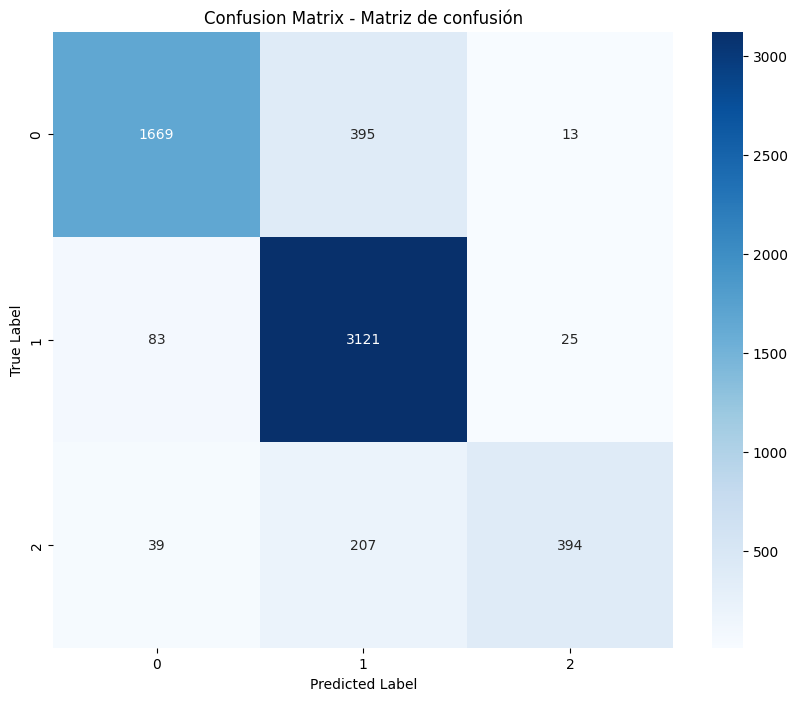

In [12]:
df = pd.read_csv('/content/Practica/datasets/Apple-Twitter-Sentiment_new.csv', sep=',', encoding='latin-1', on_bad_lines='warn')

#Aplicar el modelo a los nuevos datos:
df['processed_text'] = df['tweets'].apply(preprocess_text)
df['labels'] = df['labels'].map(label_mapping)
new_data = df[df['labels'].notnull()]

y = new_data['labels']
new_data = new_data.drop(columns='labels', errors='ignore')

predictions = pipeline.predict(new_data)
labels = sorted(y.unique())

# Evaluación del modelo con la matriz de confusión
plot_confusion_matrix(y,predictions,labels,'Matriz de confusión')

Si queremos reentrenar el modelo, podemos volver al ejercicio anterior y hacerlo con los nuevos datos:

## Reentrenamiento del modelo

In [13]:
df = pd.read_csv('/content/Practica/datasets/Apple-Twitter-Sentiment_new.csv', sep=',', encoding='latin-1', on_bad_lines='warn')
df['processed_text'] = df['tweets'].apply(preprocess_text)
df['labels'] = df['labels'].map(label_mapping)

X = df.drop(columns='labels', errors='ignore')
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Crear un pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, n_estimators=300,
    max_depth=3, learning_rate=0.3, subsample=1.0,
    colsample_bytree=0.8, gamma=0.2))
])

# Ajustar el pipeline a los datos de entrenamiento
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(max_features=1000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'processed_text')])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=...
                               feature_types=None, gamma=0.2, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

### Evaluación del modelo

No nos detendremos demasiado en los detalles de la evaluación de estos resultados. Pero supongamos que se mejora radicalmente el performance del modelo ahora con esta actualización.


=== Evaluación del Modelo sobre el Conjunto de Entrenamiento (training dataset) ===

Matriz de Confusión:


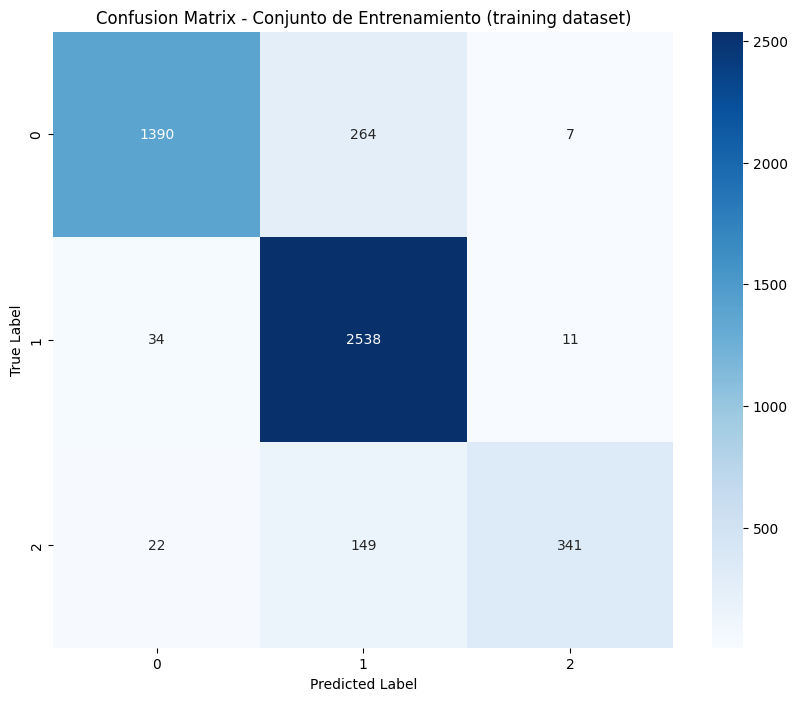


Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.84      0.89      1661
           1       0.86      0.98      0.92      2583
           2       0.95      0.67      0.78       512

    accuracy                           0.90      4756
   macro avg       0.92      0.83      0.87      4756
weighted avg       0.91      0.90      0.89      4756


Accuracy Score (Conjunto de Entrenamiento (training dataset)): 0.8976030277544155
ROC AUC para la clase 0 (Conjunto de Entrenamiento (training dataset)): 0.976
ROC AUC para la clase 1 (Conjunto de Entrenamiento (training dataset)): 0.968
ROC AUC para la clase 2 (Conjunto de Entrenamiento (training dataset)): 0.978
Average ROC AUC (Conjunto de Entrenamiento (training dataset)): 0.9741011537421594

=== Evaluación del Modelo sobre el Conjunto de Prueba (test dataset) ===

Matriz de Confusión:


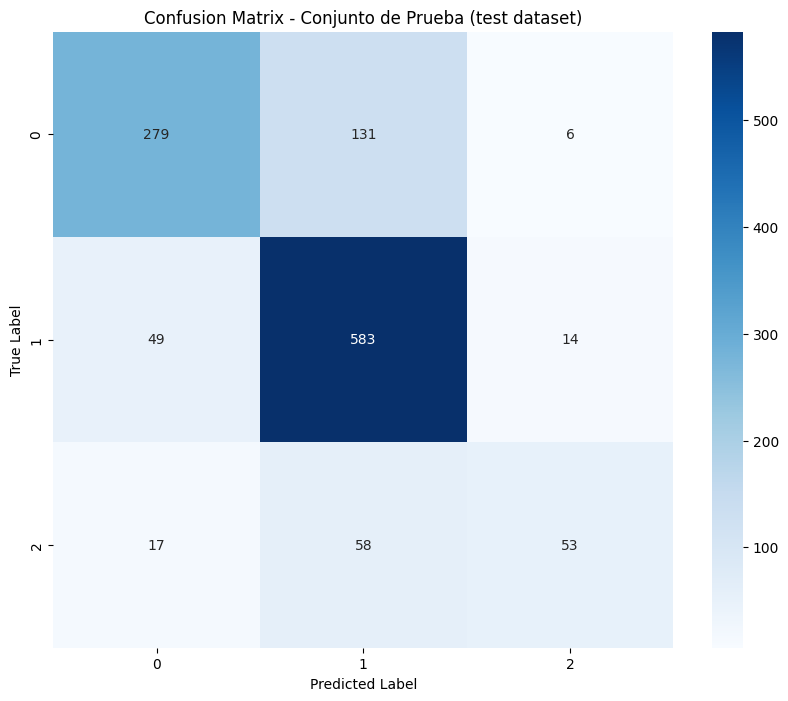


Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.81      0.67      0.73       416
           1       0.76      0.90      0.82       646
           2       0.73      0.41      0.53       128

    accuracy                           0.77      1190
   macro avg       0.76      0.66      0.69      1190
weighted avg       0.77      0.77      0.76      1190


Accuracy Score (Conjunto de Prueba (test dataset)): 0.7689075630252101
ROC AUC para la clase 0 (Conjunto de Prueba (test dataset)): 0.888
ROC AUC para la clase 1 (Conjunto de Prueba (test dataset)): 0.863
ROC AUC para la clase 2 (Conjunto de Prueba (test dataset)): 0.835
Average ROC AUC (Conjunto de Prueba (test dataset)): 0.8618335291696281


In [14]:
# Emplear el modelo predictivo sobre el conjunto de entrenamiento
train_predictions =  pipeline.predict(X_train)
train_proba = pipeline.predict_proba(X_train)

# Emplear el modelo predictivo sobre el conjunto de prueba
test_predictions = pipeline.predict(X_test)
test_proba = pipeline.predict_proba(X_test)


# Evaluar el modelo sobre ambos conjuntos
labels = sorted(y.unique())
evaluate_model(y_train, train_predictions, train_proba, labels, "Conjunto de Entrenamiento (training dataset)")
evaluate_model(y_test, test_predictions, test_proba, labels, "Conjunto de Prueba (test dataset)")

## Guardar el nuevo modelo


Dado que hemos mejorado el poder predictivo del modelo, vamos a guardar esta nueva versión. En el futuro, cargaremos esta última versión y no la anterior.

En el caso que el modelo vuelva a desajustarse, repetiremos todo el proceso desde el paso 2.


In [15]:
with mlflow.start_run(experiment_id=experiment):
  mlflow.sklearn.log_model(pipeline, "sentiment_analysis", registered_model_name="sentiment_analysis_pipeline")
  print("Model saved successfully.")

  # Set the experiment name
  mlflow.set_experiment("Actualizac_modelo")


2025/03/19 08:30:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model saved successfully.


Registered model 'sentiment_analysis_pipeline' already exists. Creating a new version of this model...
Created version '3' of model 'sentiment_analysis_pipeline'.


# **3.** Aplicar los cambios y guardarlos en GitHub

In [16]:
'''
# La primera vez, vamos a tener que generar nuestra llave única y guardarla en un sitio seguro
!ssh-keygen -t rsa -b 4096 -C "tuemail@unir.edu" -f /content/drive/MyDrive/id_rsa -N ""
print("Copia la siguiente información para crear tu acceso SSH desde gitHub")
!cat /content/drive/MyDrive/id_rsa.pub
'''

'\n# La primera vez, vamos a tener que generar nuestra llave única y guardarla en un sitio seguro\n!ssh-keygen -t rsa -b 4096 -C "tuemail@unir.edu" -f /content/drive/MyDrive/id_rsa -N ""\nprint("Copia la siguiente información para crear tu acceso SSH desde gitHub")\n!cat /content/drive/MyDrive/id_rsa.pub\n'

A continuación, vamos a leer el archivo que contiene las credenciales únicas de acceso y que hemos registrado en nuestro perfil de gitHub:

In [17]:
import subprocess
import os
# Create .ssh directory if it doesn't exist
os.makedirs(os.path.expanduser('~/.ssh'), exist_ok=True)

# Create known_hosts file if it doesn't exist
known_hosts_path = os.path.expanduser('~/.ssh/known_hosts')
if not os.path.exists(known_hosts_path):
    open(known_hosts_path, 'a').close()  # Create an empty known_hosts file

!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts

# Step 1: Start the SSH agent
def start_ssh_agent():
    # Start the SSH agent
    process = subprocess.Popen(['ssh-agent'], stdout=subprocess.PIPE)
    output, _ = process.communicate()

    # Set environment variables for the current session
    for line in output.decode().strip().split('\n'):
        if 'SSH_AUTH_SOCK' in line or 'SSH_AGENT_PID' in line:
            key, value = line.split(';')[0].strip().split('=')
            os.environ[key] = value

# Step 2: Add your private key from Google Drive
def add_private_key(key_path):
    # Add the private key to the SSH agent
    result = subprocess.run(['ssh-add', key_path], capture_output=True, text=True)
    if result.returncode == 0:
        print("SSH key added successfully.")
    else:
        print("Error adding SSH key:")
        print(result.stderr)

# Execute the functions
start_ssh_agent()

# Path to your private key in Google Drive
private_key_path = '/content/drive/MyDrive/id_rsa'  # Adjust this path as necessary

# Add the private key to the agent
add_private_key(private_key_path)

# Optional: Test SSH connection to GitHub
print("Testing SSH connection to GitHub...")
test_connection = subprocess.run(['ssh', '-T', 'git@github.com'], capture_output=True, text=True)
print(test_connection.stdout if test_connection.returncode == 0 else test_connection.stderr)


# github.com:22 SSH-2.0-7d0489107
SSH key added successfully.
Testing SSH connection to GitHub...
Hi prof-apartida! You've successfully authenticated, but GitHub does not provide shell access.



Vamos a guardar todos los cambios en nuestro repositorio de Git:

In [18]:
%cd /content/Practica
!git config --global user.name "Your Name"
!git config --global user.email "tuemail@unir.edu"

!git init
!git remote -v
!git remote remove origin

!git remote add origin git@github.com:tu_directorio/Practica.git # Cambia la dirección del repositorio

!git status
!git add .
!git commit -m "Update repository with files from Practica"
!git push -f origin main


/content/Practica
Reinitialized existing Git repository in /content/Practica/.git/
origin	https://github.com/prof-apartida/Practica.git (fetch)
origin	https://github.com/prof-apartida/Practica.git (push)
On branch main
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   mlflow/models/sentiment_analysis_pipeline/meta.yaml

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	mlflow/568786323053391264/726bb0ebbe3240af907e038897670d9c/
	mlflow/568786323053391264/78e2f53e232d49e6a65d4dfbbdeb5424/
	mlflow/899165634236523494/
	mlflow/models/sentiment_analysis_pipeline/version-3/

no changes added to commit (use "git add" and/or "git commit -a")
[main 8df22b9] Update repository with files from Practica
 48 files changed, 307 insertions(+), 1 deletion(-)
 create mode 100644 mlflow/568786323053391264/726bb0ebbe3240af907e038897670d9c/artifacts